In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
from scipy.interpolate import interp1d

In [2]:
INPUT_PATH = './example/source.png'
SOURCE_PATH = './example/target.png'

#### Import and Convert to lab

In [3]:
inputImage = cv2.imread(INPUT_PATH)
sourceImage = cv2.imread(SOURCE_PATH)

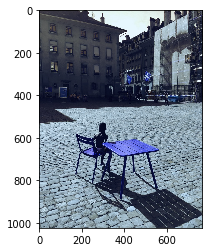

In [4]:
plt.imshow(inputImage)

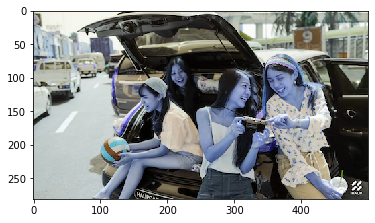

In [5]:
plt.imshow(sourceImage)

In [6]:
# inputLab = cv2.cvtColor(inputImage,cv2.COLOR_BGR2LAB).astype('float32')
# sourceLab = cv2.cvtColor(sourceImage,cv2.COLOR_BGR2LAB).astype('float32')

In [7]:
inputLab = cv2.cvtColor(inputImage,cv2.COLOR_BGR2LAB).astype('float32')
sourceLab = cv2.cvtColor(sourceImage,cv2.COLOR_BGR2LAB).astype('float32')

##### Constant

In [8]:
# Coarsest Scale
K = 5
# B-Min
B_MIN = 10
# B
B = 256

In [9]:
def findSMax() :
    return math.floor(math.log((B / B_MIN) , 2))

In [10]:
sMax = findSMax()

In [11]:
print(findSMax())

4


##### Calculate Histogram

In [12]:
sourcePlane = cv2.split(sourceLab)

In [13]:
targetPlane = cv2.split(sourceLab)

In [14]:
histSize = B
histRange = (0, 256)
accumulate = False

In [15]:
ls_hist = cv2.calcHist(sourcePlane, [0], None, [histSize], histRange, accumulate=accumulate)
as_hist = cv2.calcHist(sourcePlane, [1], None, [histSize], histRange, accumulate=accumulate)
bs_hist = cv2.calcHist(sourcePlane, [2], None, [histSize], histRange, accumulate=accumulate)

In [16]:
lt_hist = cv2.calcHist(targetPlane, [0], None, [histSize], histRange, accumulate=accumulate)
at_hist = cv2.calcHist(targetPlane, [1], None, [histSize], histRange, accumulate=accumulate)
bt_hist = cv2.calcHist(targetPlane, [2], None, [histSize], histRange, accumulate=accumulate)

In [17]:
LabsHist = [ls_hist,as_hist,bs_hist]

In [18]:
LabtHist = [lt_hist,at_hist,bt_hist]

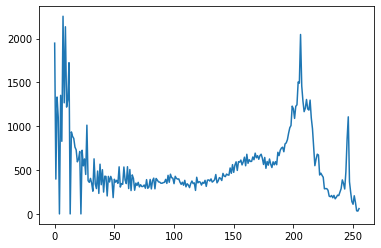

In [19]:
plt.plot(ls_hist)

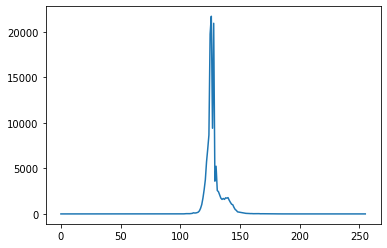

In [20]:
plt.plot(as_hist)

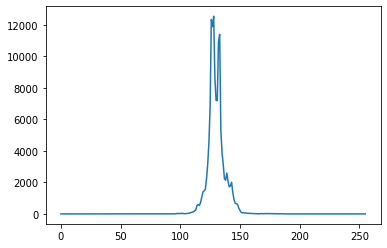

In [21]:
plt.plot(bs_hist)

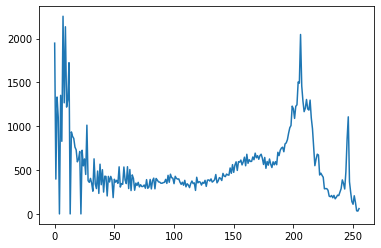

In [22]:
plt.plot(lt_hist)

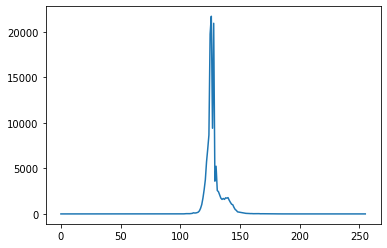

In [23]:
plt.plot(at_hist)

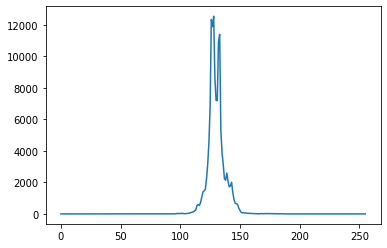

In [24]:
plt.plot(bt_hist)

#### Sampling histogram

In [25]:
def samplingHistogram(histogram):
    return upSampling(downSampling(histogram))

In [26]:
def downSampling(histogram):
    x = np.arange(B)
    y = histogram.flatten()
    bicublic = interp1d(x, y,'cubic')
    downSampling = bicublic(x)
    return np.array(downSampling, ndmin=2)

In [27]:
def upSampling(histogram):
    x = np.arange(B)
    y = histogram.flatten()
    nnInterpolate = interp1d(x, y,'nearest')
    upSampling = nnInterpolate(x)
    return shapingSampling(upSampling)

In [28]:
def shapingSampling(histogram):
    result = []
    for x in histogram:
        result.append(x)
    result = np.array(result, ndmin=1)
    return result

#### Find Peak

In [29]:
def findPeak(histogram, k, s, b):
    RminSet = []
    for i in range(0,histogram.size-1):
        if( (findDifH(histogram,k,s,i,b)*findDifH(histogram,k,s,i+1,b) > 0) 
           and findSecondDifH(histogram,k,s,i,b) > 0) :
            RminSet.append(i)
    return RminSet

In [30]:
def findDifH(histogram,k,s,i,b):    
    if(i in range(0, int(findBk(k,b,s)-1))):
        return histogram[i] - histogram[i+1]
    return 0

In [31]:
def findBk(k,b,Smax):
    return b * pow(2, (k-Smax))

In [32]:
def findSecondDifH(histogram,k,s,i,b):
    if(i in range(0, int(findBk(k,b,s)-2))):
        return 2*histogram[i+1] - histogram[i+2] - histogram[i]
    return 0

#### Region Transfer

In [33]:
def regionTransfer(Hs,Ht,wt):
    if(len(Hs) != 1 and len(Ht) != 1):
        ws = 1.1-wt
        Ho = (Hs-ws*Hs.mean()) * ((wt*Ht.std())/(ws*Hs.std())) + wt*Ht.mean()
        return Ho
    return Hs

#### Map Histogram back to Image

In [34]:
def calculate_cdf(histogram):
    # Get the cumulative sum of the elements
    cdf = histogram.cumsum()
 
    # Normalize the cdf
    normalized_cdf = cdf / float(cdf.max())
 
    return normalized_cdf

In [35]:
def calculate_lookup(src_cdf, ref_cdf):
    """
    This method creates the lookup table
    :param array src_cdf: The cdf for the source image
    :param array ref_cdf: The cdf for the reference image
    :return: lookup_table: The lookup table
    :rtype: array
    """
    lookup_table = np.zeros(B)
    lookup_val = 0
    for src_pixel_val in range(len(src_cdf)):
        lookup_val
        for ref_pixel_val in range(len(ref_cdf)):
            if ref_cdf[ref_pixel_val] >= src_cdf[src_pixel_val]:
                lookup_val = ref_pixel_val
                break
        lookup_table[src_pixel_val] = lookup_val
    return lookup_table

#### Algorithm

In [36]:
shapedHistogram = []
for channel in range(0,3):
    Hs = LabsHist[channel].copy()
    Ht = LabtHist[channel].copy()
    for k in range(1, sMax+1):
        Hs = samplingHistogram(Hs)
        Ht = samplingHistogram(Ht)
        RminT = findPeak(Ht,k,sMax, B)
        if(len(RminT) != 0):
            for index, minBound in enumerate(RminT):
                if(minBound != Hs.size and index != len(RminT)-1):
                    Hs[minBound:RminT[index+1]] = regionTransfer(
                        Hs[minBound:RminT[index+1]],
                        Ht[minBound:RminT[index+1]],
                        k/sMax
                    )
        RminS = findPeak(Hs,k,sMax, B)
        if(len(RminS) != 0):
            for index, minBound in enumerate(RminS):
                if(minBound != Ht.size and index != len(RminS)-1):
                    Ht[minBound:RminS[index+1]] = regionTransfer(
                        Hs[minBound:RminS[index+1]],
                        Ht[minBound:RminS[index+1]],
                        k/sMax
                    )
    shapedHistogram.append(Ht)

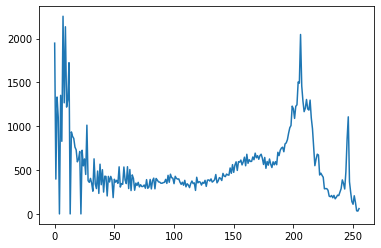

In [37]:
plt.plot(LabtHist[0],label='before l')

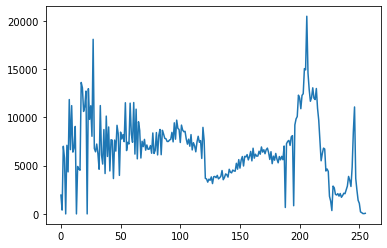

In [38]:
plt.plot(shapedHistogram[0],label='before l')

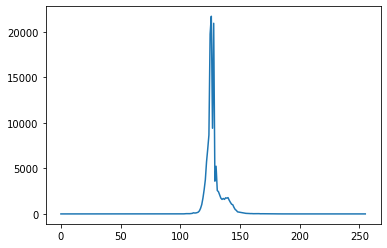

In [39]:
plt.plot(LabtHist[1],label='before a')

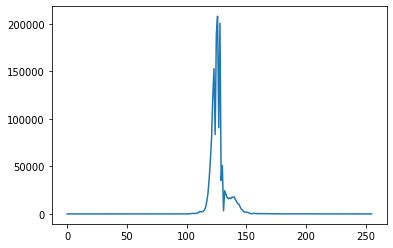

In [40]:
plt.plot(shapedHistogram[1],label='after a')

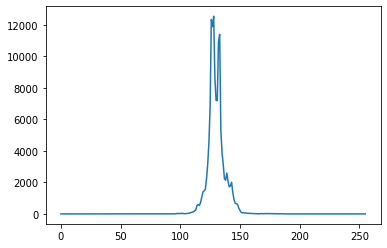

In [41]:
plt.plot(LabtHist[2],label='before b')

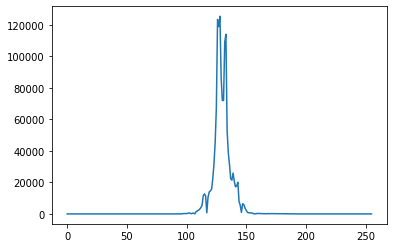

In [42]:
plt.plot(shapedHistogram[2],label='after b')

In [43]:
original_l_cdf = calculate_cdf(LabtHist[0].astype(np.uint8))
original_a_cdf = calculate_cdf(LabtHist[1].astype(np.uint8))
original_b_cdf = calculate_cdf(LabtHist[2].astype(np.uint8))
transfer_cdf_l = calculate_cdf(shapedHistogram[0].astype(np.uint8))
transfer_cdf_a = calculate_cdf(shapedHistogram[1].astype(np.uint8))
transfer_cdf_b = calculate_cdf(shapedHistogram[2].astype(np.uint8))

In [44]:
l_lookup_table = calculate_lookup(original_l_cdf, transfer_cdf_l)
a_lookup_table = calculate_lookup(original_a_cdf, transfer_cdf_a)
b_lookup_table = calculate_lookup(original_b_cdf, transfer_cdf_b)

In [45]:
l_after_transform = cv2.LUT(targetPlane[0].astype(np.uint8), l_lookup_table)
a_after_transform = cv2.LUT(targetPlane[1].astype(np.uint8), a_lookup_table)
b_after_transform = cv2.LUT(targetPlane[2].astype(np.uint8), b_lookup_table)

In [46]:
image_after_matching = cv2.merge([
        l_after_transform, a_after_transform, b_after_transform])

In [47]:
image_after_matching = cv2.convertScaleAbs(image_after_matching)

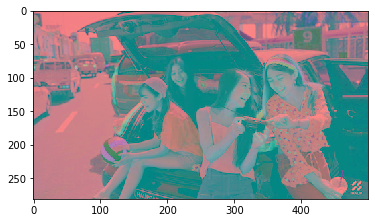

In [49]:
plt.imshow(image_after_matching)

In [50]:
image_after_matching = cv2.cvtColor(image_after_matching, cv2.COLOR_LAB2RGB).astype('float32')

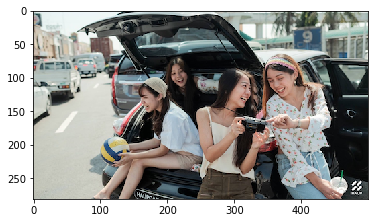

In [51]:
plt.imshow(cv2.cvtColor(sourceImage,cv2.COLOR_BGR2RGB))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


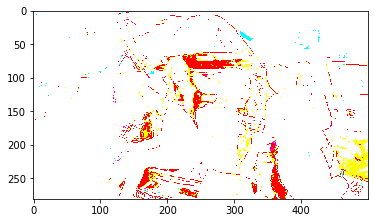

In [52]:
plt.imshow(image_after_matching)